In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import json
import random

# ============================================================
# Quantum Emoji Encoder: one-cell full demo
# ============================================================
#
# 1. Define canonical emoji moods with valence/arousal metadata
# 2. Convert mood into a qubit state |ψ> = α|sad> + β|happy>
# 3. Plot that state on the Bloch sphere
# 4. "Measure" (collapse) to an emoji based on |α|^2, |β|^2
# 5. Generalize to N-emotion superposition and plot probabilities
# 6. Save pretty figures to outputs/
#
# ============================================================

# ---------- setup ----------
os.makedirs("outputs", exist_ok=True)
os.makedirs("data", exist_ok=True)

EMOJI_DB = {
    "😢": {"valence": -0.8, "arousal": 0.3, "tone": "sad"},
    "😊": {"valence":  0.9, "arousal": 0.4, "tone": "warm-happy"},
    "😏": {"valence":  0.6, "arousal": 0.5, "tone": "playful-sarcastic"},
    "😡": {"valence": -0.7, "arousal": 0.9, "tone": "angry-hot"},
    "😱": {"valence": -0.4, "arousal": 1.0, "tone": "panic/fear"},
    "😍": {"valence":  1.0, "arousal": 0.8, "tone": "in-love"}
}

with open("data/emoji_map.json", "w", encoding="utf-8") as f:
    json.dump(EMOJI_DB, f, ensure_ascii=False, indent=2)

# ============================================================
# Part A. Qubit model: 2D emotion space (sad vs happy)
# We treat |0> = 😢 (sad), |1> = 😊 (happy)
#
# Any pure state can be written:
#   |ψ(θ,φ)> = cos(θ/2)|0> + e^{iφ} sin(θ/2)|1>
#
# We map:
#   valence in [-1,1] -> θ in [π,0]   (more positive valence => closer to |happy>)
#   sarcasm_phase in [0, 2π) -> φ
# ============================================================

def mood_to_qubit(valence, sarcasm_phase):
    # map valence [-1,1] -> theta [π,0]
    theta = np.pi * (1 - (valence + 1)/2.0)
    phi = sarcasm_phase % (2*np.pi)

    alpha = np.cos(theta/2)                   # amplitude for |sad> (😢)
    beta  = np.exp(1j*phi)*np.sin(theta/2)    # amplitude for |happy> (😊)

    state = np.array([alpha, beta], dtype=complex)
    # numerical normalize
    norm = np.linalg.norm(state)
    if norm == 0:
        state = np.array([1.0+0j,0.0+0j])
        theta = np.pi
        phi = 0.0
    else:
        state = state / norm

    return state, theta, phi

# pick an internal mood to demo:
# you can change these numbers to get different vibes:
# valence = how good you feel (-1 very bad, +1 amazing)
# sarcasm_phase = 0 sincere / π snarky / etc.
demo_valence = 0.4          # slightly positive, not pure joy
demo_sarcasm_phase = np.pi/2  # "playful / teasing"
state, theta, phi = mood_to_qubit(demo_valence, demo_sarcasm_phase)

# compute measurement probabilities
probs = np.abs(state)**2
P_sad, P_happy = probs[0], probs[1]

# collapse simulation
basis_emojis = ["😢","😊"]
collapsed_emoji = np.random.choice(basis_emojis, p=probs)

# ============================================================
# Part B. Bloch sphere plot for this qubit
# Bloch coordinates:
#   x = sinθ cosφ
#   y = sinθ sinφ
#   z = cosθ
#
# We'll draw:
#   - the unit sphere
#   - axes
#   - the state's Bloch vector
# ============================================================

def plot_bloch(theta, phi, save_path="outputs/bloch_sphere_example.png"):
    # Bloch vector
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Bloch Sphere: Your Emotional Qubit", fontsize=12)

    # sphere surface
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v))
    Z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(X, Y, Z, rstride=2, cstride=2, color="#e0e0e0", alpha=0.25, edgecolor="none")

    # axes
    ax.quiver(0,0,0, 1,0,0, color='red',   linewidth=2)
    ax.quiver(0,0,0, 0,1,0, color='green', linewidth=2)
    ax.quiver(0,0,0, 0,0,1, color='blue',  linewidth=2)
    ax.text(1.1,0,0,"x",color='red')
    ax.text(0,1.1,0,"y",color='green')
    ax.text(0,0,1.1,"z",color='blue')

    # state vector
    ax.quiver(0,0,0, x,y,z, color='black', linewidth=3)
    ax.scatter([x],[y],[z], color='black', s=60)
    ax.text(x*1.2, y*1.2, z*1.2, "your state", color='black')

    # pretty limits
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_box_aspect([1,1,1])
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)

plot_bloch(theta, phi)

# ============================================================
# Part C. N-emoji superposition
#
# We now allow multiple canonical emojis with arbitrary weights.
# Example: blend of anger (😡), sadness (😢), and love (😍).
#
# We'll:
#   1. Take user raw weights
#   2. Normalize to sum to 1
#   3. Treat those as |α_k|^2 (classical probs of collapse)
#   4. Plot bar chart and save
#
# This is the "multi-level emotional wavefunction".
# ============================================================

raw_blend = {
    "😡": 0.40,  # angry
    "😢": 0.35,  # sad
    "😍": 0.25   # in love
}

# normalize weights to make them probabilities
weights = np.array(list(raw_blend.values()), dtype=float)
weights = weights / weights.sum()  # now sum to 1
multi_emojis = list(raw_blend.keys())

def plot_superposition(emojis, probs, save_path="outputs/mood_superposition.png"):
    fig, ax = plt.subplots(figsize=(5,3))
    ax.bar(emojis, probs, color=["#ff4d4d","#4d79ff","#ff66cc"])
    ax.set_ylim([0,1])
    ax.set_ylabel("Probability of collapse")
    ax.set_title("Multi-Emoji Superposition")
    for i,p in enumerate(probs):
        ax.text(i, p+0.02, f"{p:.2f}", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)

plot_superposition(multi_emojis, weights)

# ============================================================
# Part D. Pretty combined teaser figure for README
# We'll stitch a 2-panel teaser:
# left: Bloch sphere snapshot (we'll just reload saved img)
# right: bar chart snapshot
#
# This will be "README_teaser.png"
# ============================================================

import matplotlib.image as mpimg

def make_teaser(
    bloch_img_path="outputs/bloch_sphere_example.png",
    super_img_path="outputs/mood_superposition.png",
    save_path="outputs/README_teaser.png"
):
    bimg = mpimg.imread(bloch_img_path)
    simg = mpimg.imread(super_img_path)

    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].imshow(bimg)
    axs[0].axis("off")
    axs[0].set_title("Quantum mood state on Bloch sphere")

    axs[1].imshow(simg)
    axs[1].axis("off")
    axs[1].set_title("Multi-emoji collapse probabilities")

    fig.suptitle("Quantum Emoji Encoder: Feelings as Qubits", fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)

make_teaser()

# ============================================================
# Part E. Print scientific summary to console
# This text is what you'd screenshot into the README.
# ============================================================

print("========== QUANTUM EMOJI ENCODER REPORT ==========")
print("Internal mood parameters:")
print(f"  valence ([-1..1]): {demo_valence:.3f}")
print(f"  sarcasm_phase (rad): {demo_sarcasm_phase:.3f}")
print()
print("Qubit state |ψ> = α|😢> + β|😊>:")
print(f"  α (sad 😢)   = {state[0]:.4f}")
print(f"  β (happy 😊) = {state[1]:.4f}")
print()
print("Measurement probabilities:")
print(f"  P(😢 sad)   = {P_sad:.4f}")
print(f"  P(😊 happy) = {P_happy:.4f}")
print()
print(f"Simulated collapse result (you actually send): {collapsed_emoji}")
print()
print("Multi-emoji blend (generalized N-state superposition):")
for emo, p in zip(multi_emojis, weights):
    meta = EMOJI_DB.get(emo, {})
    tone = meta.get("tone","?")
    val  = meta.get("valence","?")
    aro  = meta.get("arousal","?")
    print(f"  {emo} : {p:.3f}   tone={tone}   valence={val}   arousal={aro}")

print()
print("Saved figures:")
print("  outputs/bloch_sphere_example.png      (Bloch sphere of mood qubit)")
print("  outputs/mood_superposition.png        (N-emoji probability bars)")
print("  outputs/README_teaser.png             (2-panel marketing image)")
print()
print("Core idea:")
print("  |ψ> = α|sad😢> + β|happy😊>,  |α|^2+|β|^2=1.")
print("  Picking one emoji is quantum measurement (wavefunction collapse).")
print("===================================================")


========== QUANTUM EMOJI ENCODER REPORT ==========
Internal mood parameters:
  valence ([-1..1]): 0.400
  sarcasm_phase (rad): 1.571

Qubit state |ψ> = α|😢> + β|😊>:
  α (sad 😢)   = 0.8910+0.0000j
  β (happy 😊) = 0.0000+0.4540j

Measurement probabilities:
  P(😢 sad)   = 0.7939
  P(😊 happy) = 0.2061

Simulated collapse result (you actually send): 😢

Multi-emoji blend (generalized N-state superposition):
  😡 : 0.400   tone=angry-hot   valence=-0.7   arousal=0.9
  😢 : 0.350   tone=sad   valence=-0.8   arousal=0.3
  😍 : 0.250   tone=in-love   valence=1.0   arousal=0.8

Saved figures:
  outputs/bloch_sphere_example.png      (Bloch sphere of mood qubit)
  outputs/mood_superposition.png        (N-emoji probability bars)
  outputs/README_teaser.png             (2-panel marketing image)

Core idea:
  |ψ> = α|sad😢> + β|happy😊>,  |α|^2+|β|^2=1.
  Picking one emoji is quantum measurement (wavefunction collapse).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

valences = np.linspace(-1,1,50)
entropy = []
for v in valences:
    state,_θ,_φ = mood_to_qubit(v, np.pi/2)
    p = np.abs(state)**2
    H = -np.sum(p*np.log2(p + 1e-12))
    entropy.append(H)

plt.figure(figsize=(5,3))
plt.plot(valences, entropy, color='purple')
plt.xlabel("Valence (-1 = sad, +1 = happy)")
plt.ylabel("Shannon Entropy (bits)")
plt.title("Entropy of Emotional Expression")
plt.tight_layout()
plt.savefig("outputs/emotional_entropy.png", dpi=300)
plt.close()


In [3]:
import matplotlib.pyplot as plt

val = np.linspace(-1,1,100)
phi = np.linspace(0,2*np.pi,100)
Z = np.zeros((len(val), len(phi)))
for i,v in enumerate(val):
    for j,p in enumerate(phi):
        s,_θ,_φ = mood_to_qubit(v,p)
        P_happy = np.abs(s[1])**2
        Z[i,j] = P_happy

plt.figure(figsize=(5,4))
plt.imshow(Z, extent=[0,2*np.pi,-1,1], origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label="P(😊 happy)")
plt.xlabel("Phase φ (sarcasm angle)")
plt.ylabel("Valence")
plt.title("Quantum Phase Map of Emotion")
plt.tight_layout()
plt.savefig("outputs/phase_map.png", dpi=300)
plt.close()


In [4]:
import random

trials = 200
collapse_results = [np.random.choice(["😢","😊"], p=np.abs(mood_to_qubit(0.2, np.pi/3)[0])**2) for _ in range(trials)]

plt.figure(figsize=(6,2))
plt.scatter(range(trials), [1 if c=="😊" else 0 for c in collapse_results], s=10, color='teal')
plt.yticks([0,1],["😢","😊"])
plt.xlabel("Trial (moment of expression)")
plt.title("Wavefunction Collapses Over Time")
plt.tight_layout()
plt.savefig("outputs/collapse_timeline.png", dpi=300)
plt.close()


In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

paths = [
  "outputs/bloch_sphere_example.png",
  "outputs/mood_superposition.png",
  "outputs/emotional_entropy.png",
  "outputs/phase_map.png",
  "outputs/collapse_timeline.png"
]

fig, axs = plt.subplots(2,3,figsize=(12,7))
for i,ax in enumerate(axs.ravel()[:5]):
    img = mpimg.imread(paths[i])
    ax.imshow(img)
    ax.axis("off")
axs.ravel()[-1].text(0.5,0.5,"Quantum Emoji Encoder\nFeelings as Qubits",
                     ha="center",va="center",fontsize=18,fontweight="bold")
axs.ravel()[-1].axis("off")
plt.tight_layout()
plt.savefig("outputs/quantum_emoji_grid.png", dpi=300)
plt.close()


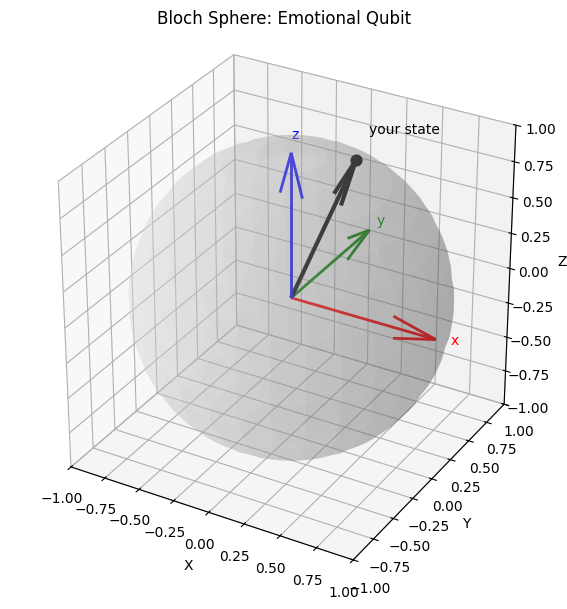

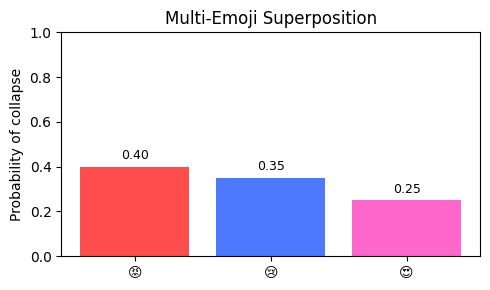

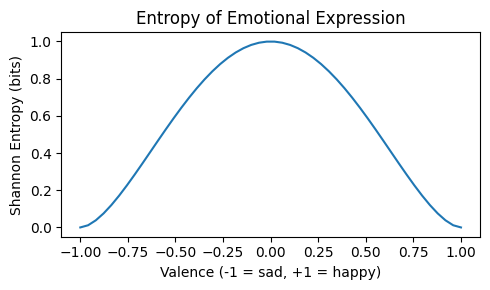

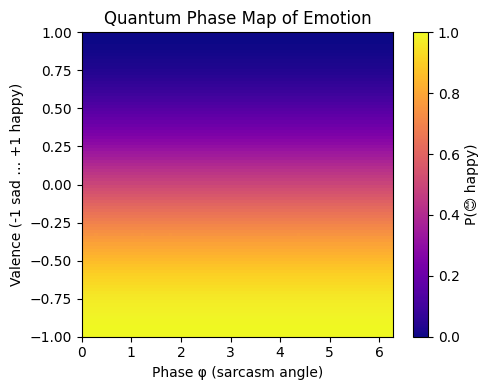

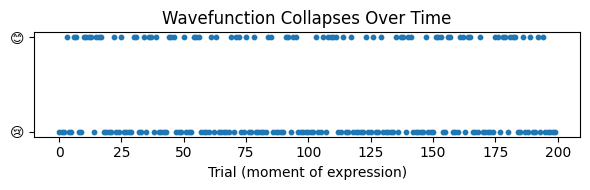

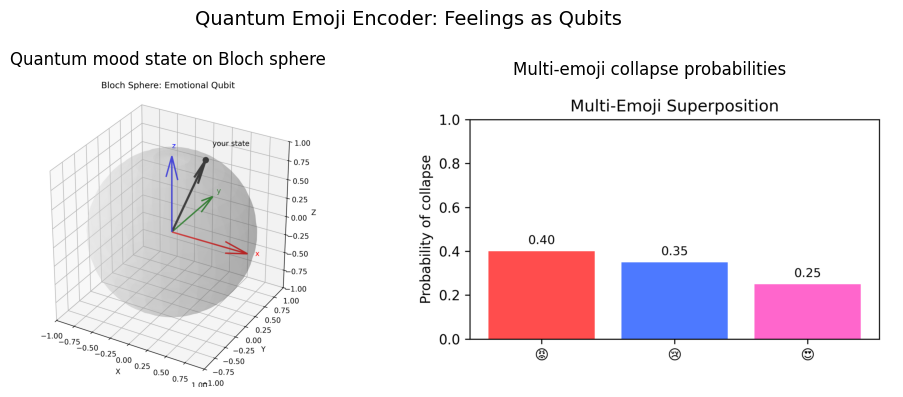

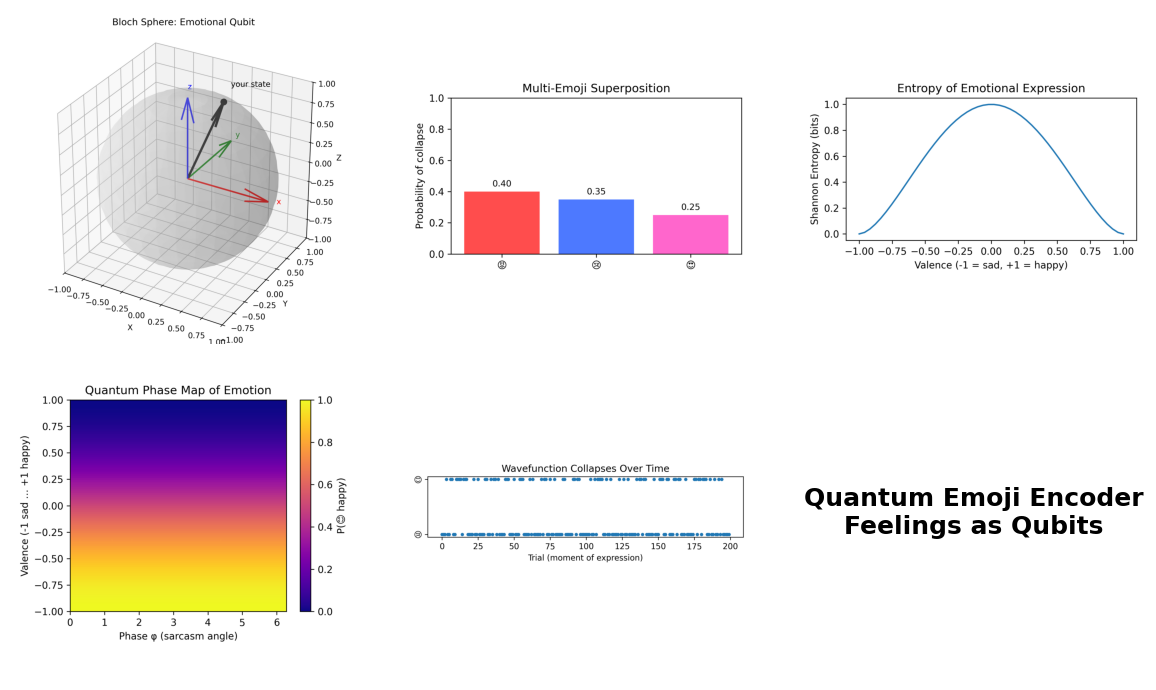

========== QUANTUM EMOJI ENCODER REPORT ==========
Internal mood parameters:
  valence ([-1..1]): 0.400
  sarcasm_phase (rad): 1.571

Qubit state |ψ> = α|😢> + β|😊> :
  α (sad 😢)   = 0.8910+0.0000j
  β (happy 😊) = 0.0000+0.4540j

Measurement probabilities:
  P(😢 sad)   = 0.7939
  P(😊 happy) = 0.2061

Simulated collapse result (you actually send): 😢

Multi-emoji blend (N-state superposition):
  😡 : 0.400   tone=angry-hot   valence=-0.7   arousal=0.9
  😢 : 0.350   tone=sad   valence=-0.8   arousal=0.3
  😍 : 0.250   tone=in-love   valence=1.0   arousal=0.8

Saved figures:
  outputs/bloch_sphere_example.png
  outputs/mood_superposition.png
  outputs/emotional_entropy.png
  outputs/phase_map.png
  outputs/collapse_timeline.png
  outputs/README_teaser.png
  outputs/quantum_emoji_grid.png


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import os
import json

# ============================================================
# Setup folders and emoji database
# ============================================================

os.makedirs("outputs", exist_ok=True)
os.makedirs("data", exist_ok=True)

EMOJI_DB = {
    "😢": {"valence": -0.8, "arousal": 0.3, "tone": "sad"},
    "😊": {"valence":  0.9, "arousal": 0.4, "tone": "warm-happy"},
    "😏": {"valence":  0.6, "arousal": 0.5, "tone": "playful-sarcastic"},
    "😡": {"valence": -0.7, "arousal": 0.9, "tone": "angry-hot"},
    "😱": {"valence": -0.4, "arousal": 1.0, "tone": "panic/fear"},
    "😍": {"valence":  1.0, "arousal": 0.8, "tone": "in-love"}
}

with open("data/emoji_map.json", "w", encoding="utf-8") as f:
    json.dump(EMOJI_DB, f, ensure_ascii=False, indent=2)

# ============================================================
# Helper 1: mood -> qubit state
# ============================================================

def mood_to_qubit(valence, sarcasm_phase):
    theta = np.pi * (1 - (valence + 1)/2.0)  # valence [-1,1] -> theta [π,0]
    phi = sarcasm_phase % (2*np.pi)

    alpha = np.cos(theta/2)                   # amplitude for |sad>   (😢)
    beta  = np.exp(1j*phi)*np.sin(theta/2)    # amplitude for |happy> (😊)

    state = np.array([alpha, beta], dtype=complex)
    norm = np.linalg.norm(state)
    if norm == 0:
        state = np.array([1.0+0j,0.0+0j])
        theta = np.pi
        phi = 0.0
    else:
        state = state / norm
    return state, theta, phi

# choose demo internal mood
demo_valence = 0.4
demo_sarcasm_phase = np.pi/2
state, theta, phi = mood_to_qubit(demo_valence, demo_sarcasm_phase)

probs = np.abs(state)**2
P_sad, P_happy = probs[0], probs[1]
basis_emojis = ["😢","😊"]
collapsed_emoji = np.random.choice(basis_emojis, p=probs)

# ============================================================
# FIGURE 1: Bloch sphere plot
# ============================================================

def plot_bloch(theta, phi, save_path="outputs/bloch_sphere_example.png", show_inline=True):
    # Bloch coords
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Bloch Sphere: Emotional Qubit", fontsize=12)

    # draw sphere
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v))
    Z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(X, Y, Z, rstride=2, cstride=2,
                    color="#e0e0e0", alpha=0.25, edgecolor="none")

    # axes
    ax.quiver(0,0,0, 1,0,0, color='red',   linewidth=2)
    ax.quiver(0,0,0, 0,1,0, color='green', linewidth=2)
    ax.quiver(0,0,0, 0,0,1, color='blue',  linewidth=2)
    ax.text(1.1,0,0,"x",color='red')
    ax.text(0,1.1,0,"y",color='green')
    ax.text(0,0,1.1,"z",color='blue')

    # emotional state vector
    ax.quiver(0,0,0, x,y,z, color='black', linewidth=3)
    ax.scatter([x],[y],[z], color='black', s=60)
    ax.text(x*1.2, y*1.2, z*1.2, "your state", color='black')

    # limits
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_box_aspect([1,1,1])
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.tight_layout()

    # save
    plt.savefig(save_path, dpi=300)
    if show_inline:
        plt.show()
    plt.close(fig)

plot_bloch(theta, phi, show_inline=True)

# ============================================================
# FIGURE 2: Multi-emoji probability bars
# ============================================================

raw_blend = {
    "😡": 0.40,  # angry
    "😢": 0.35,  # sad
    "😍": 0.25   # in love
}

def plot_superposition(blend_dict, save_path="outputs/mood_superposition.png", show_inline=True):
    emojis = list(blend_dict.keys())
    weights = np.array(list(blend_dict.values()), dtype=float)
    weights = weights / weights.sum()  # normalize -> probs that sum to 1

    fig, ax = plt.subplots(figsize=(5,3))
    ax.bar(emojis, weights, color=["#ff4d4d","#4d79ff","#ff66cc"][:len(emojis)])
    ax.set_ylim([0,1])
    ax.set_ylabel("Probability of collapse")
    ax.set_title("Multi-Emoji Superposition")
    for i,p in enumerate(weights):
        ax.text(i, p+0.02, f"{p:.2f}", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300)
    if show_inline:
        plt.show()
    plt.close(fig)

plot_superposition(raw_blend, show_inline=True)

# keep normalized probs for summary print later
multi_emojis = list(raw_blend.keys())
multi_probs = np.array(list(raw_blend.values()), dtype=float)
multi_probs = multi_probs / multi_probs.sum()

# ============================================================
# FIGURE 3: Entropy vs valence
# ============================================================

def emotional_entropy_curve(save_path="outputs/emotional_entropy.png", show_inline=True):
    valences = np.linspace(-1,1,50)
    entropy_bits = []
    for v in valences:
        s, _θ, _φ = mood_to_qubit(v, np.pi/2)  # fix sarcasm phase
        p = np.abs(s)**2
        H = -np.sum(p * np.log2(p + 1e-12))
        entropy_bits.append(H)

    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(valences, entropy_bits)
    ax.set_xlabel("Valence (-1 = sad, +1 = happy)")
    ax.set_ylabel("Shannon Entropy (bits)")
    ax.set_title("Entropy of Emotional Expression")
    plt.tight_layout()

    plt.savefig(save_path, dpi=300)
    if show_inline:
        plt.show()
    plt.close(fig)

emotional_entropy_curve(show_inline=True)

# ============================================================
# FIGURE 4: Phase map (valence vs sarcasm phase)
# ============================================================

def phase_map(save_path="outputs/phase_map.png", show_inline=True):
    val = np.linspace(-1,1,100)
    phi_grid = np.linspace(0,2*np.pi,100)
    Z = np.zeros((len(val), len(phi_grid)))
    for i,v in enumerate(val):
        for j,p_ in enumerate(phi_grid):
            s, _θ, _φ = mood_to_qubit(v, p_)
            P_happy = np.abs(s[1])**2
            Z[i,j] = P_happy

    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(
        Z,
        extent=[0,2*np.pi,-1,1],
        origin='lower',
        aspect='auto',
        cmap='plasma'
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("P(😊 happy)")
    ax.set_xlabel("Phase φ (sarcasm angle)")
    ax.set_ylabel("Valence (-1 sad … +1 happy)")
    ax.set_title("Quantum Phase Map of Emotion")
    plt.tight_layout()

    plt.savefig(save_path, dpi=300)
    if show_inline:
        plt.show()
    plt.close(fig)

phase_map(show_inline=True)

# ============================================================
# FIGURE 5: Collapse timeline (stochastic emoji outcomes)
# ============================================================

def collapse_timeline(
    valence=0.2,
    sarcasm_phase=np.pi/3,
    trials=200,
    save_path="outputs/collapse_timeline.png",
    show_inline=True
):
    s, _θ, _φ = mood_to_qubit(valence, sarcasm_phase)
    p = np.abs(s)**2
    # map outcome 0->😢 and 1->😊 for plotting
    data = np.random.choice([0,1], size=trials, p=p)

    fig, ax = plt.subplots(figsize=(6,2))
    ax.scatter(range(trials), data, s=10)
    ax.set_yticks([0,1])
    ax.set_yticklabels(["😢","😊"])
    ax.set_xlabel("Trial (moment of expression)")
    ax.set_title("Wavefunction Collapses Over Time")
    plt.tight_layout()

    plt.savefig(save_path, dpi=300)
    if show_inline:
        plt.show()
    plt.close(fig)

collapse_timeline(show_inline=True)

# ============================================================
# FIGURE 6: Teaser panel (Bloch + Superposition)
# ============================================================

def teaser_panel(
    bloch_path="outputs/bloch_sphere_example.png",
    multi_path="outputs/mood_superposition.png",
    save_path="outputs/README_teaser.png",
    show_inline=True
):
    bimg = mpimg.imread(bloch_path)
    simg = mpimg.imread(multi_path)

    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].imshow(bimg)
    axs[0].axis("off")
    axs[0].set_title("Quantum mood state on Bloch sphere")

    axs[1].imshow(simg)
    axs[1].axis("off")
    axs[1].set_title("Multi-emoji collapse probabilities")

    fig.suptitle("Quantum Emoji Encoder: Feelings as Qubits", fontsize=14)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300)
    if show_inline:
        plt.show()
    plt.close(fig)

teaser_panel(show_inline=True)

# ============================================================
# FIGURE 7: Master grid (2x3 collage for README banner)
# ============================================================

def master_grid(save_path="outputs/quantum_emoji_grid.png", show_inline=True):
    paths = [
        "outputs/bloch_sphere_example.png",
        "outputs/mood_superposition.png",
        "outputs/emotional_entropy.png",
        "outputs/phase_map.png",
        "outputs/collapse_timeline.png"
    ]

    fig, axs = plt.subplots(2,3,figsize=(12,7))
    flat = axs.ravel()

    for i in range(5):
        img = mpimg.imread(paths[i])
        flat[i].imshow(img)
        flat[i].axis("off")

    flat[5].text(
        0.5,0.5,
        "Quantum Emoji Encoder\nFeelings as Qubits",
        ha="center", va="center",
        fontsize=18, fontweight="bold"
    )
    flat[5].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    if show_inline:
        plt.show()
    plt.close(fig)

master_grid(show_inline=True)

# ============================================================
# console summary (for README screenshot)
# ============================================================

print("========== QUANTUM EMOJI ENCODER REPORT ==========")
print("Internal mood parameters:")
print(f"  valence ([-1..1]): {demo_valence:.3f}")
print(f"  sarcasm_phase (rad): {demo_sarcasm_phase:.3f}")
print()
print("Qubit state |ψ> = α|😢> + β|😊> :")
print(f"  α (sad 😢)   = {state[0]:.4f}")
print(f"  β (happy 😊) = {state[1]:.4f}")
print()
print("Measurement probabilities:")
print(f"  P(😢 sad)   = {P_sad:.4f}")
print(f"  P(😊 happy) = {P_happy:.4f}")
print()
print(f"Simulated collapse result (you actually send): {collapsed_emoji}")
print()
print("Multi-emoji blend (N-state superposition):")
for emo, p in zip(multi_emojis, multi_probs):
    meta = EMOJI_DB.get(emo, {})
    tone = meta.get("tone","?")
    val  = meta.get("valence","?")
    aro  = meta.get("arousal","?")
    print(f"  {emo} : {p:.3f}   tone={tone}   valence={val}   arousal={aro}")

print()
print("Saved figures:")
print("  outputs/bloch_sphere_example.png")
print("  outputs/mood_superposition.png")
print("  outputs/emotional_entropy.png")
print("  outputs/phase_map.png")
print("  outputs/collapse_timeline.png")
print("  outputs/README_teaser.png")
print("  outputs/quantum_emoji_grid.png")
print("===================================================")
